<a href="https://colab.research.google.com/github/farhan1503001/Deep-Learning-Rhyme-Projects/blob/main/Facial_Keypoints_Detection_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import helper

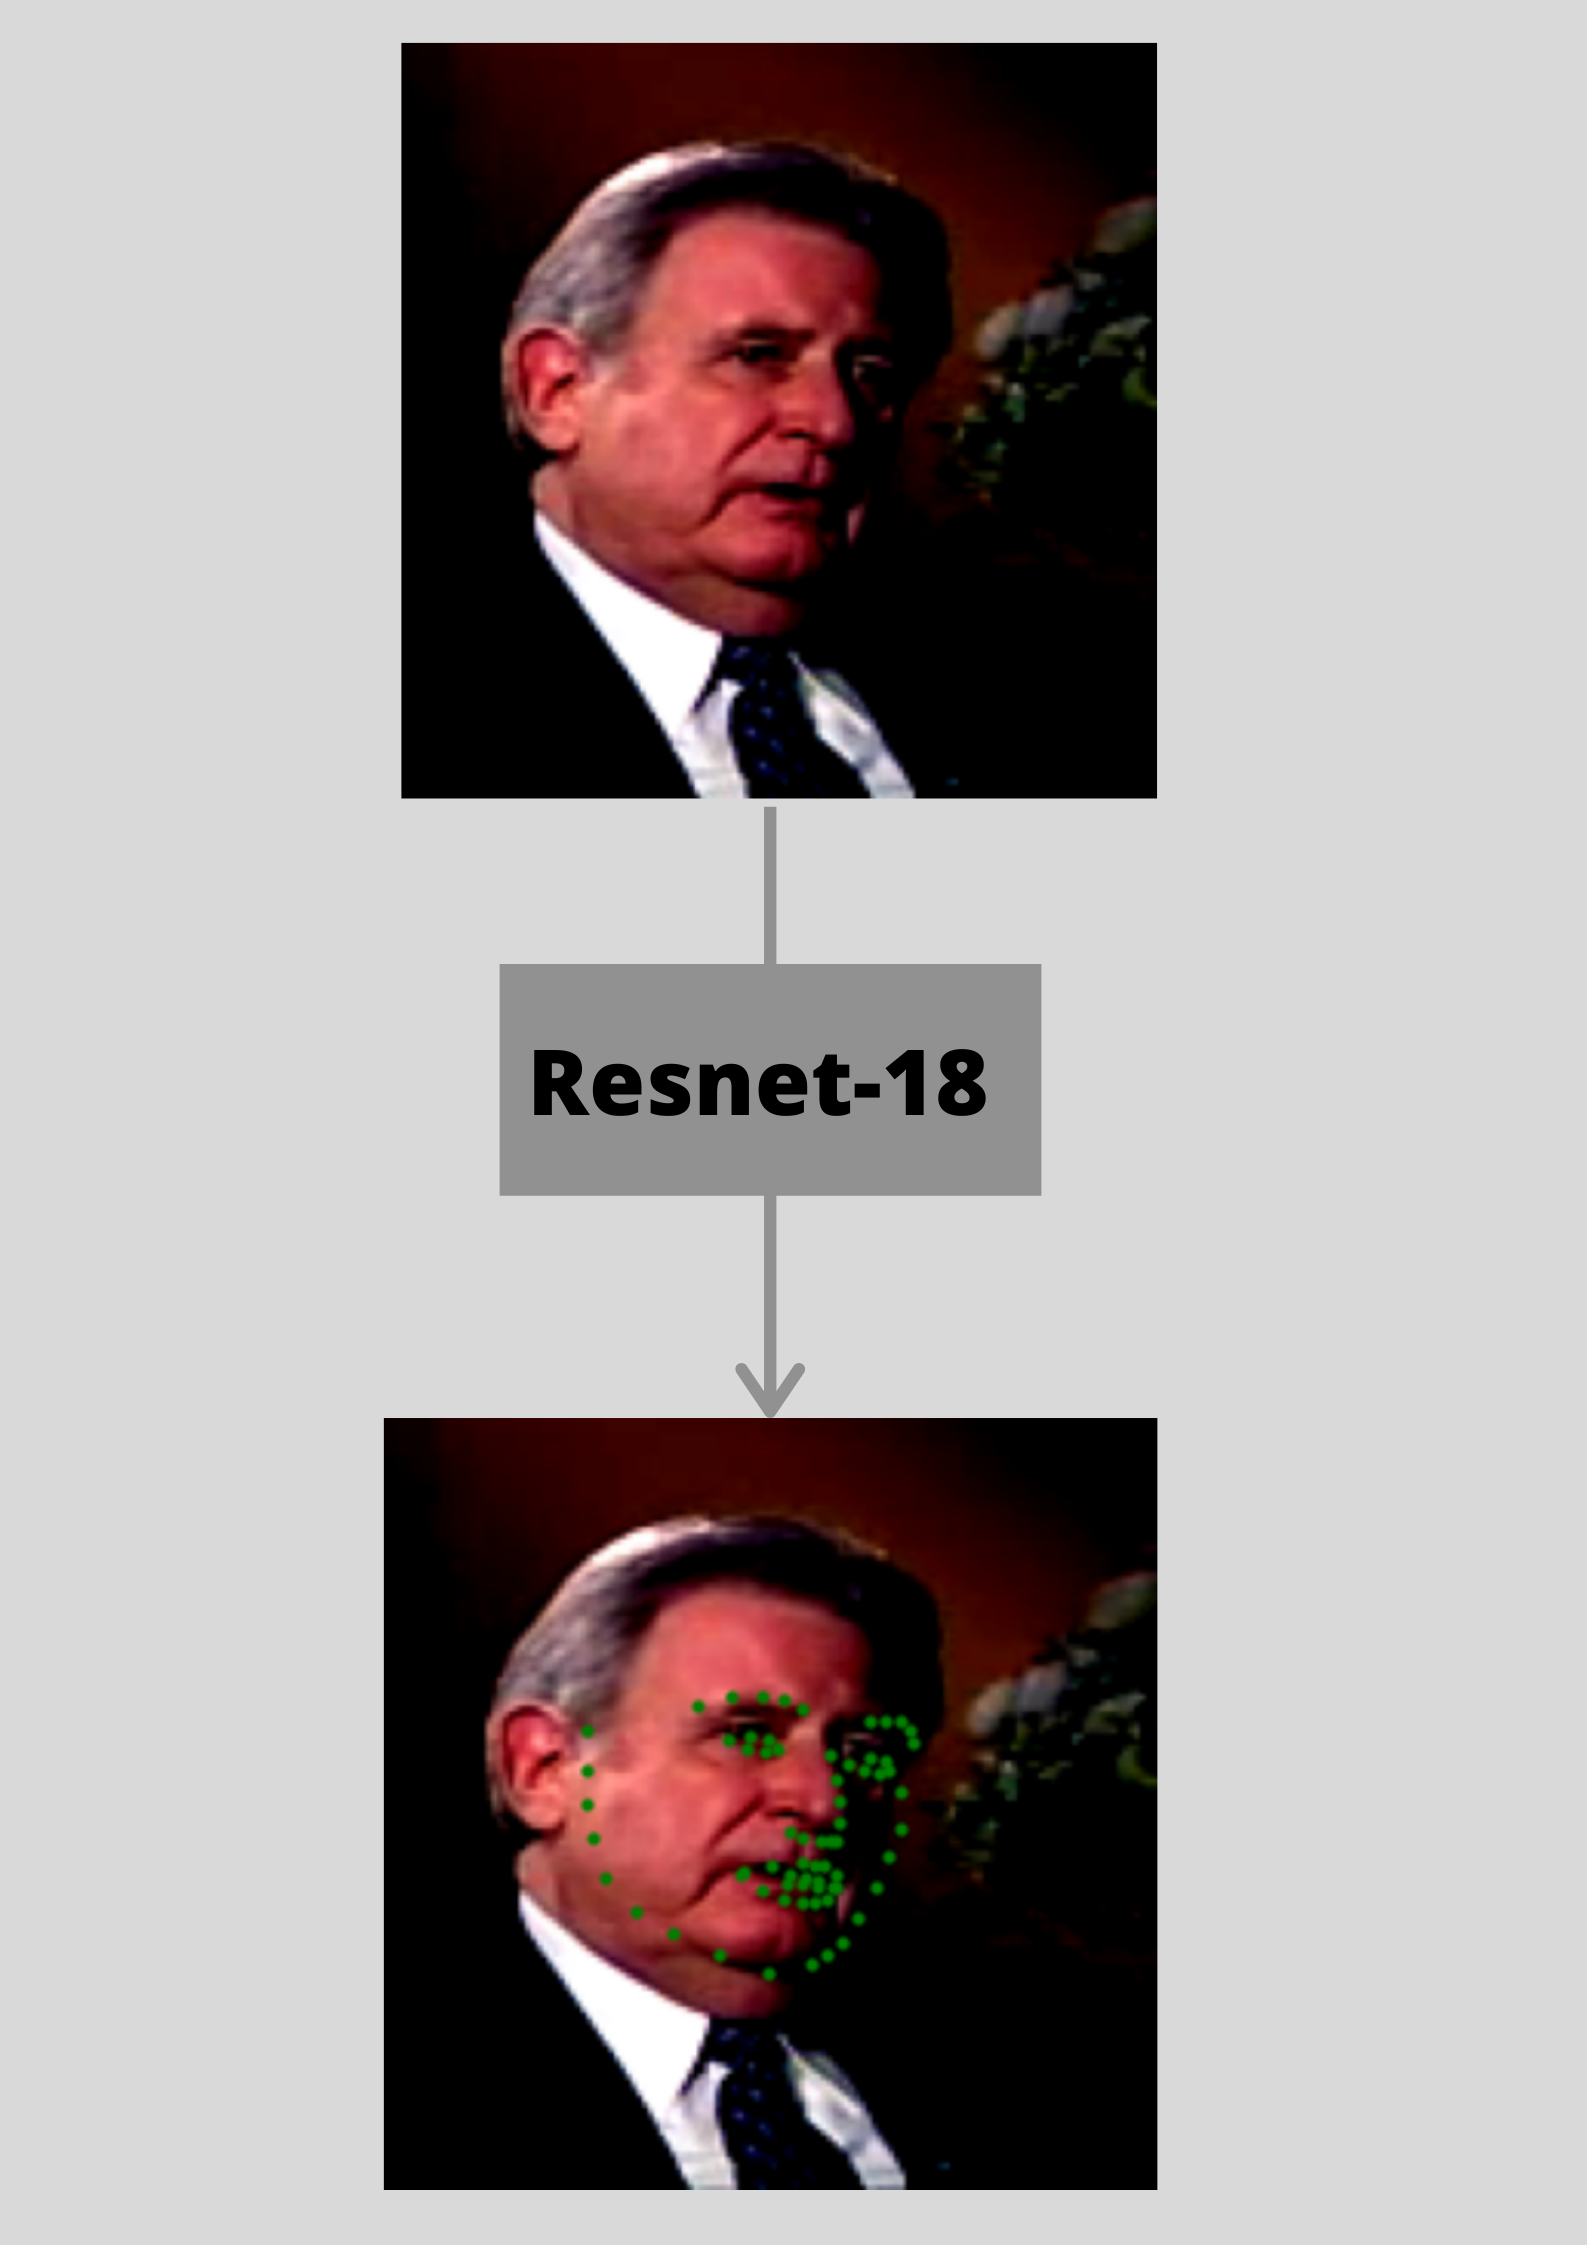

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
!unzip -q '/content/drive/MyDrive/data.zip'

replace __MACOSX/._data? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/test_frames_keypoints.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/training_frames_keypoints.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/test/Lesia_Burlak_00.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Configs

In [43]:
main_dir='/content/data/'
training_dir='/content/data/training/'
testing_dir='/content/data/test/'
train_csv='/content/data/training_frames_keypoints.csv'
test_csv='/content/data/test_frames_keypoints.csv'

DEVICE='cuda'
Batch_size=16
IMG_SIZE=140
LR=0.001
EPOCHS=2
MODEL_NAME='resnet18'

# Understand Facial Keypoint Dataset

In [44]:
#First reading the train and test csv dataframe
train_df=pd.read_csv(train_csv)
test_df=pd.read_csv(test_csv)
train_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [45]:
#Now visualizing the data
idx=5
image_name=train_df['Unnamed: 0'].iloc[idx]
image_path=training_dir+image_name
image=cv2.imread(image_path)
#Now converting the image from bgr to rgb
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#Now keypoint pixel values which are in 136 coloums we will convert them to 68,2
key=train_df.iloc[idx][1:].to_numpy().reshape(-1,2)
print(key)


[[67.0 134.0]
 [69.0 144.0]
 [72.0 154.0]
 [77.0 165.0]
 [79.0 175.0]
 [87.0 185.0]
 [95.0 193.0]
 [105.0 201.0]
 [120.0 201.0]
 [133.0 196.0]
 [138.0 189.0]
 [143.0 181.0]
 [149.0 168.0]
 [151.0 158.0]
 [151.0 148.0]
 [151.0 138.0]
 [149.0 127.0]
 [79.0 131.0]
 [84.0 129.0]
 [92.0 129.0]
 [97.0 129.0]
 [105.0 129.0]
 [123.0 127.0]
 [128.0 127.0]
 [133.0 125.0]
 [138.0 125.0]
 [143.0 125.0]
 [115.0 140.0]
 [115.0 147.0]
 [118.0 155.0]
 [118.0 160.0]
 [110.0 165.0]
 [113.0 165.0]
 [118.0 165.0]
 [120.0 165.0]
 [123.0 163.0]
 [87.0 137.0]
 [92.0 137.0]
 [97.0 137.0]
 [102.0 137.0]
 [97.0 139.0]
 [92.0 139.0]
 [123.0 135.0]
 [128.0 132.0]
 [133.0 132.0]
 [138.0 132.0]
 [133.0 135.0]
 [128.0 137.0]
 [102.0 178.0]
 [108.0 175.0]
 [115.0 173.0]
 [118.0 173.0]
 [123.0 173.0]
 [128.0 173.0]
 [133.0 176.0]
 [128.0 181.0]
 [125.0 183.0]
 [120.0 186.0]
 [115.0 186.0]
 [110.0 181.0]
 [105.0 175.0]
 [115.0 175.0]
 [118.0 176.0]
 [123.0 176.0]
 [131.0 176.0]
 [123.0 178.0]
 [120.0 181.0]
 [115.0 181

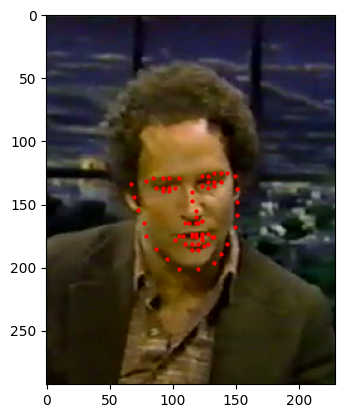

In [46]:
#Now we will visualize
plt.imshow(image)
plt.scatter(key[:,0],key[:,1],s=4,c='r')

# Dividing the training and test set

In [47]:
train_df,valid_df=train_test_split(train_df,test_size=0.20,random_state=42)

# Create Custom Facial Keypoint Dataset

albumentation : https://albumentations.ai/docs/  <br>

albumentation for keypoints : https://albumentations.ai/docs/examples/example_keypoints/

In [48]:
import albumentations as A
from torch.utils.data import Dataset

In [49]:
#Now importing albumentation library for data augmentation
class FacialKeypointDataset(Dataset):
  def __init__(self,df,img_dir,augmentation=None):
    self.df=df
    self.image_dir=img_dir
    self.augmentation=augmentation

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    image_path=self.image_dir+self.df['Unnamed: 0'].iloc[idx]
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    key=self.df.iloc[idx][1:].to_numpy().reshape(-1,2)

    if self.augmentation:
      augmented_data=self.augmentation(image=image,keypoints=key)
      image=torch.from_numpy(augmented_data['image']).float()
      key=torch.tensor(augmented_data['keypoints']).float()

    #Now time to return
    return image.permute(2,0,1),key.view(-1) #flattens the tensor

In [50]:
#Now writing augementations for training and test data
train_augs=A.Compose(
    [
        A.Resize(IMG_SIZE,IMG_SIZE),
        A.Normalize(),
        #A.HorizontalFlip(p=0.5)
    ]
,keypoint_params=A.KeypointParams(format='xy',remove_invisible=False)
)

In [51]:
valid_augs=A.Compose(
    [
        A.Resize(IMG_SIZE,IMG_SIZE),
        A.Normalize()
    ],
    keypoint_params=A.KeypointParams(format='xy',remove_invisible=False)
)

In [52]:
trainset=FacialKeypointDataset(train_df,training_dir,train_augs)
validset=FacialKeypointDataset(valid_df,training_dir,valid_augs)
testset=FacialKeypointDataset(test_df,testing_dir,valid_augs)

In [53]:
print("Total no. of examples present in trainset : {}".format(len(trainset)))
print("Total no. of examples present in validset : {}".format(len(validset)))

Total no. of examples present in trainset : 2769
Total no. of examples present in validset : 693


In [54]:
import numpy as np
def show_with_key(image,key):
  #Now convert tensor to numpy array
  image=image.permute(1,2,0).cpu().detach().numpy()
  key=key.view(-1,2).cpu().detach().numpy()

  image=image*np.array([0.485,0.456,0.406])+np.array([0.229,0.224,0.225])

  plt.imshow(image)
  plt.scatter(key[:,0],key[:,1],s=10,c='r')

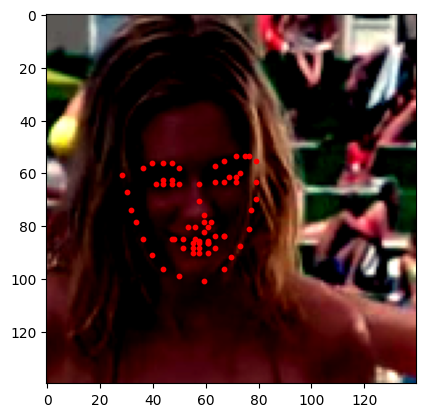

In [55]:
img,key=trainset[56]
show_with_key(img,key)

# Load Dataset into Batches

In [56]:
#Now we will write dataloader
trainloader=torch.utils.data.DataLoader(trainset,batch_size=Batch_size,shuffle=True)
validloader=torch.utils.data.DataLoader(validset,batch_size=Batch_size,shuffle=False)

In [57]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 174
Total no. batches in validloader : 44


In [58]:
for data in trainloader:
  img,key=data
  break
print("Image size: ",img.shape)
print("Keyset size: ",key.shape)

Image size:  torch.Size([16, 3, 140, 140])
Keyset size:  torch.Size([16, 136])


# Create Model

ckeck out timm : https://rwightman.github.io/pytorch-image-models/ (documentation), https://github.com/rwightman/pytorch-image-models (github repo)

In [59]:
!pip install timm

In [60]:
import timm

In [61]:
#Now creating the model
class FacialKeyModel(torch.nn.Module):
  def __init__(self,model_name=MODEL_NAME):
    super(FacialKeyModel,self).__init__()
    self.backbone=timm.create_model(model_name=model_name,pretrained=True,num_classes=136)
    print("Backbone Loade Complete")

  def forward(self,images,keys=None):

    logits=self.backbone(images)
    if keys!=None:
      return logits,torch.nn.MSELoss()(logits,keys)

    return logits



In [62]:
model=FacialKeyModel(MODEL_NAME)
model.to(DEVICE);

Backbone Loade Complete


In [63]:
model(torch.randn(16,3,140,140).to('cuda')).shape

torch.Size([16, 136])

# Trainer and Evaluator

In [64]:
from pyparsing import rest_of_line
def train_function(model,trainloader,optimizer):
  train_loss=0.0
  model.train()
  for data in tqdm(trainloader):
    images,keys=data

    images=images.to(DEVICE)
    keys=keys.to(DEVICE)

    logits,loss=model(images,keys)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss+=loss.item()

  return train_loss/len(trainloader)

In [65]:
def valid_function(model,validloader):
  valid_loss=0.0
  model.eval()
  with torch.no_grad():
    for data in tqdm(validloader):
      images,keys=data
      images=images.to(DEVICE)
      keys=keys.to(DEVICE)

      logits,loss=model(images,keys)
      valid_loss+=loss.item()

    return valid_loss/len(validloader)

# Training model

In [66]:
optimizer=torch.optim.Adam(params=model.parameters(),lr=LR)
best_valid_loss=np.Inf
for epoch in range(20):
  train_loss=train_function(model,trainloader,optimizer)
  valid_loss=valid_function(model,validloader)
  if valid_loss<best_valid_loss:
    print("Model is saved")
    torch.save(model.state_dict(),"FaceModel.pt")
    best_valid_loss=valid_loss
  print(f"{epoch}/{20} training loss {train_loss} validation loss {valid_loss}")

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Model is saved
0/20 training loss 1520.074291908878 validation loss 51.66847640817816


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Model is saved
1/20 training loss 41.100336118676196 validation loss 41.40108958157626


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Model is saved
2/20 training loss 40.235910492381834 validation loss 38.39255124872381


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Model is saved
3/20 training loss 37.82550183657942 validation loss 34.59357656132091


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Model is saved
4/20 training loss 25.375006204363945 validation loss 25.185872901569713


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Model is saved
5/20 training loss 20.76706783798919 validation loss 18.128891923210837


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

6/20 training loss 19.136615073543854 validation loss 32.96727826378562


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Model is saved
7/20 training loss 16.165240139796815 validation loss 14.258382233706387


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Model is saved
8/20 training loss 13.153609492312903 validation loss 14.16016080162742


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Model is saved
9/20 training loss 11.01819021400364 validation loss 8.881681062958457


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Model is saved
10/20 training loss 10.461329010711319 validation loss 8.467571670358831


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

11/20 training loss 9.095404315268857 validation loss 10.401848836378617


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Model is saved
12/20 training loss 7.521887265402695 validation loss 5.550620463761416


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Model is saved
13/20 training loss 6.180146794209535 validation loss 4.705036336725408


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Model is saved
14/20 training loss 5.403843364496341 validation loss 4.33354264497757


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

15/20 training loss 5.117268565057338 validation loss 8.53390062939037


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

16/20 training loss 4.561820820145224 validation loss 4.378213920376518


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

17/20 training loss 3.9827790239761613 validation loss 4.491915556517514


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

18/20 training loss 3.8455577602331665 validation loss 5.905597957697782


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

19/20 training loss 3.8263786195338456 validation loss 6.947719909928062


# Visualizing Predictions

In [69]:
def compare_keypoints(image, key, out_key):
	image = image.squeeze().permute(1,2,0)
	image = image.cpu().detach().numpy()
	image = image * np.array([0.485, 0.456, 0.406]) + np.array([0.229, 0.224, 0.225])

	f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

	ax1.set_title('original-keypoints')
	ax1.imshow(image)
	key = key.view(-1,2).cpu().detach().numpy()
	ax1.scatter(key[:,0],key[:,1], s = 10, c = 'b')

	ax2.set_title('model-keypoints')
	ax2.imshow(image)
	out_key = out_key.view(-1,2).cpu().detach().numpy()
	ax2.scatter(out_key[:,0],out_key[:,1], s = 10, c = 'g')


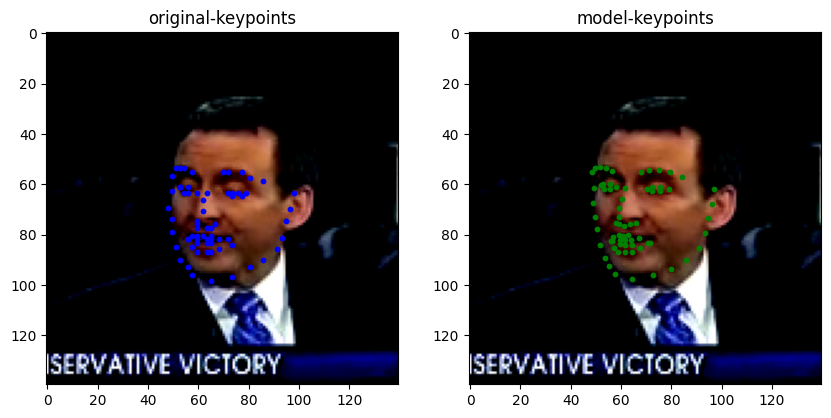

In [70]:
import helper
index=9
image,key=testset[index]
model.load_state_dict(torch.load('FaceModel.pt',map_location=DEVICE))
model.eval()
with torch.no_grad():
  image=image.to(DEVICE)
  out_key=model(image.unsqueeze(0))
  compare_keypoints(image,key,out_key)